# TODO:
- create validation set (section 3 requires it)
- moving processing of product description into eda as a preprocess
- ~~adding mean_absolute_error to Word section~~
- combine history graph with flat metrics for non NN models
- make validation split consistent
- ~~time each model with %%time like the cell below~~ (Chen: I've added ```%%time``` to all cells that train stuff, but I think time.time() is better)
- write report


- (optional but easy) refactor the repeated 6 cells of evaluating a model to a function and call it
- (Optional) check if classification is better
- (Optional) preprocess of  product description by bullets/ removing words with number

# Practical Deep Learning Workshop 2021
## Assignment 3 - Word Embeddings
 
### Authors:
 
1.   Chen Doytshman 205644941
2.   Naor Kolet 205533060


# 0. Preliminary

## a. Imports

In [1]:
import pandas as pd
import numpy as np
 
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate
from tensorflow.keras.layers import Dropout, Dense, Lambda, Multiply, Subtract, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error

# XGBoost
from xgboost import XGBRegressor

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
import random
import time
from tqdm import tqdm_notebook as tqdm

SEED = 42
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 100)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
import zipfile
DATA_DIR = 'home-depot-product-search-relevance'

files = [f for f in os.listdir(DATA_DIR) if f.endswith('zip')]
for file in tqdm(files):
    with zipfile.ZipFile(f'{DATA_DIR}/{file}') as zf:
        zf.extractall(DATA_DIR)
        os.remove(f'{DATA_DIR}/{file}')

## b. Collecting Results
throughout this notebook we are going to collect the results for the different models, on-the-fly. Later, we will discuss them in section 3 of this assignment.

In [4]:
from prettytable import PrettyTable
results = PrettyTable(['Model type', 'Runtime', 'Train RMSE',
                       'Val-RMSE', 'Test-RMSE', 'Train MAE', 
                       'Val-MAE', 'Test-MAE'], hrules=True)
results.float_format = ".4"

## c. Data Preparation, EDA

Let's load the data:

In [5]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv', index_col='id', encoding='latin-1')
product_desc_df = pd.read_csv(f'{DATA_DIR}/product_descriptions.csv', index_col='product_uid')
attributes_df = pd.read_csv(f'{DATA_DIR}/attributes.csv', index_col=['product_uid'], dtype={'product_uid': 'Int64'})

In [6]:
test_path = f'{DATA_DIR}/test_labels.csv'
if os.path.exists(test_path):
    test_df = pd.read_csv(test_path)
else:
    test_df = pd.read_csv(f'{DATA_DIR}/test.csv', index_col='id', encoding='latin-1')
    sol = pd.read_csv(f'{DATA_DIR}/solution.csv', index_col='id', encoding='latin-1')
    test_df = test_df[sol.relevance != -1]
    test_df = test_df.join(sol.relevance, on='id')
    test_df.to_csv(test_path)

In [7]:
train_df.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),shower only faucet,2.67


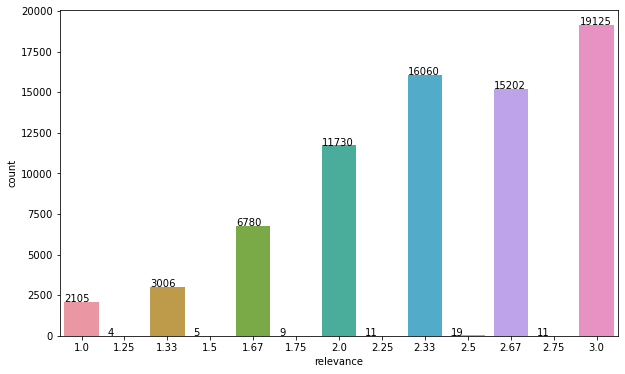

In [8]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=train_df, x="relevance")

relevance_values = train_df["relevance"].value_counts().sort_index()

for p, label in zip(ax.patches, relevance_values):
    ax.annotate(label, (p.get_x(), p.get_height()+0.5))

In [9]:
product_desc_df.head()

,product_description
product_uid,
100001,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si..."
100002,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, wea..."
100003,"Classic architecture meets contemporary design in the Ensemble Curve series, made of solid Vikre..."
100004,The Grape Solar 265-Watt Polycrystalline PV Solar Panel bonus pack bundles 4 Grape Solar 265-Wat...
100005,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...


In [10]:
product_desc_df.iloc[0, 0]

'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws'

In [11]:
attributes_df[attributes_df.index.isin([100001])]

,name,value
product_uid,,
100001,Bullet01,Versatile connector for various 90° connections and home repair projects
100001,Bullet02,Stronger than angled nailing or screw fastening alone
100001,Bullet03,Help ensure joints are consistently straight and strong
100001,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
100001,Bullet05,Made from 12-Gauge steel
100001,Bullet06,Galvanized for extra corrosion resistance
100001,Bullet07,Install with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws
100001,Gauge,12
100001,Material,Galvanized Steel


def concat_attr(record):
    name, value = record
    name = f'{name} ' if not name.startswith('Bullet') else '' # Delete name if it's a "Bullet.."
    return f'{name}{value} ;'

product_groups = attributes_df.groupby('product_uid')
for product_uid, df in product_groups:
    joined_attrs = ' '.join(map(concat_attr, df.values))
    product_desc_df.loc[product_uid, 'concat_desc'] = joined_attrs

product_desc_df

TODO: explain the connection between description and attributes

## d. Preprocessing

In [12]:
def join_desc(df):
    df = df.join(product_desc_df['product_description'], on='product_uid')
    df['product_description'] = df['product_title'] + ' : ' + df['product_description']
    df = df[['product_uid', 'search_term', 'product_description', 'relevance']]
    return df

train_df = join_desc(train_df)
test_df = join_desc(test_df)

TODO: explain the replacement of items' description column

# 1. Character level LSTM

## Using character level processing to predict search relevance

### a. Preprocess the data to contain sequences of single characters

In [13]:
def tokenize_serie(serie):
    serie = pd.Series(map(lambda x: list(map(ord, list(x))), serie.values), index=serie.index)
    max_len = min(serie.apply(len).max(), 1500)
    return pad_sequences(serie, max_len, padding='post')

In [14]:
def split_x_y(df):
    search_term = tokenize_serie(df['search_term'])
    description = tokenize_serie(df['product_description'])
    
    search_term, description = map(lambda x: np.expand_dims(x,axis=2), [search_term, description])
    return (search_term, description), df['relevance'].values

In [15]:
train_x_char, train_y_char = split_x_y(train_df)
test_x_char, test_y_char = split_x_y(test_df)

### b. Constructing a Siamese network

https://github.com/prabhnoor0212/Siamese-Network-Text-Similarity

TODO: Remove extra functions

In [16]:
from tensorflow.keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [17]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [18]:
sm = 0

def common_model(length):
    global sm
    inp = Input(shape=(length, 1))
    X = Conv1D(64, 10, activation='relu')(inp)
    X = MaxPooling1D()(X)
    X = Flatten()(X)
    X = Activation('relu')(X)
    X = Dense(128, activation='relu')(X)
    
    sm += 1
    return Model(inp, X, name=f'siamese_model_{sm}')

In [19]:
common_model(128).summary()

Model: "siamese_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 64)           704       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3776)              0         
_________________________________________________________________
activation (Activation)      (None, 3776)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               483456    
Total params: 484,160
Trainable params: 484,160
Non-trainable params: 0
_____________________________________________

In [20]:
def init_siamese_model(search_term_len, product_description_len, output_shape=1):
    input_1 = Input(shape=(search_term_len, 1))
    input_2 = Input(shape=(product_description_len, 1))
    
    lstm_1 = LSTM(128)(input_1)
    lstm_2 = LSTM(128)(input_2)
    
    expand_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="expand_dim_layer")
    
    expended_1 = expand_layer(lstm_1)
    expended_2 = expand_layer(lstm_2)
    
    sm = common_model(128)

    vector_1 = sm(expended_1)
    
    vector_2 = sm(expended_2)
    
    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
    
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(conc)
    x = Dropout(0.01)(x)
    out = Dense(output_shape, activation="relu", name = 'out')(x)

    model = Model([input_1, input_2], out)

    model.compile(loss='mse', metrics=['mae'], optimizer=Adam())
    
    return model

In [21]:
init_siamese_model(train_x_char[0].shape[1],train_x_char[1].shape[1]).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1500, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          66560       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          66560       input_3[0][0]                    
______________________________________________________________________________________________

#### Training framework

In [22]:
def get_callbacks(model_name):
    acc = 'val_loss'
    acc_mode = 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=4)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 3,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR, earlystop]

In [23]:
def visualize_perf(history):
    fig, ax = plt.subplots(ncols=2, figsize=(5*2,5))
    fig.suptitle(f'Model performance over epochs')
    
    for k in ['loss', 'val_loss']:
        ax[0].plot(history[k])
        
    ax[0].legend(['train_mse', 'val_mse'])
    ax[0].margins(0.01)
    ax[0].set_title('mse')
    
    for k in ['mae', 'val_mae']:
        ax[1].plot(history[k])
        
    ax[1].legend(['train_mae', 'val_mae'])
    ax[1].margins(0.01)
    ax[1].set_title('mae')
    
    plt.show()


In [24]:
def train_model(model_gen, train_data, batch_size=128, use_saved=False):
    os.makedirs('./models', exist_ok=True)
    model_name = model_gen.__name__[5:]
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
        
        (train_st, train_desc), train_rel = train_data
        model = model_gen(train_st.shape[1],train_desc.shape[1])
        history = model.fit(
                            x=[train_st, train_desc],
                            y=train_rel,
                            batch_size=batch_size,
                            epochs=20,
                            validation_split=0.2,
                            callbacks=callbacks
                            )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')
    
    return model, history

In [25]:
%%time
start = time.time()
char_model, char_history = train_model(init_siamese_model, (train_x_char, train_y_char), use_saved=True)
end = time.time()

CPU times: user 826 ms, sys: 22.7 ms, total: 849 ms
Wall time: 957 ms


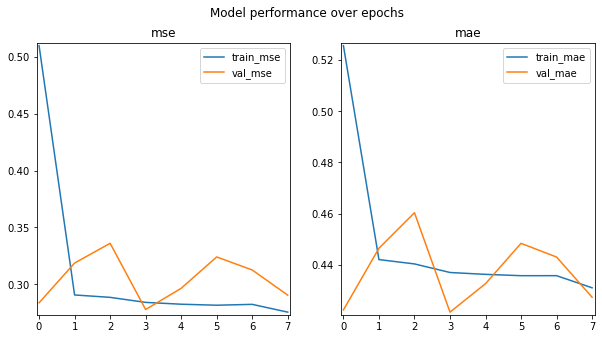

In [26]:
visualize_perf(char_history)

In [27]:
train_preds_char = char_model.predict(train_x_char)

In [28]:
train_mse = mean_squared_error(train_preds_char, train_y_char)
train_mae = mean_absolute_error(train_preds_char, train_y_char)
train_rmse = mean_squared_error(train_preds_char, train_y_char, squared=False)

print(f'MSE of {train_mse:.4f} on the train')
print(f'MAE of {train_mae:.4f} on the train')
print(f'RMSE of {train_rmse:.4f} on the train')

MSE of 0.2814 on the train
MAE of 0.4398 on the train
RMSE of 0.5304 on the train


### turn below 2 cells to code from raw after having val set

In [29]:
test_preds_char = char_model.predict(test_x_char)

In [30]:
test_mse = mean_squared_error(test_preds_char, test_y_char)
test_mae = mean_absolute_error(test_preds_char, test_y_char)
test_rmse = mean_squared_error(test_preds_char, test_y_char, squared=False)

print(f'MAE loss on test set: {test_mse:.4f}')
print(f'MSE loss on test set: {test_mse:.4f}')
print(f'RMSE loss on test set: {test_rmse:.4f}')

MAE loss on test set: 0.2845
MSE loss on test set: 0.2845
RMSE loss on test set: 0.5334


In [31]:
runtime = end - start
val_rmse, val_mae = 0, 0 # Remove this line after having a val set
results.add_row(['LSTM (character level)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### c. Naïve model-based benchmark with ```CountVectorizer```

TODO: MARKDOWN

#### Preprocessing

In [32]:
desc_series = train_df['product_description']
search_term_series = train_df['search_term']
desc_st = pd.concat([desc_series, search_term_series])
corpus = desc_st.values
vectorizer = CountVectorizer(analyzer='char')
vectorizer.fit(corpus)
print(vectorizer.get_feature_names())

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '\x89', '\x90', '\x95', '¡', '¢', 'ª', 'à', 'ã', 'å', 'è', 'ê', 'ò', '÷', 'û', 'ü']


In [33]:
def prepare_data_naive(df):
    desc_series = df['product_description']
    search_term_series = df['search_term']
    counts_desc = vectorizer.transform(desc_series).toarray()
    counts_st = vectorizer.transform(search_term_series).toarray()
    X = np.concatenate([counts_desc, counts_st], axis=1)
    Y = df['relevance'].values
    return X, Y

In [34]:
train_x_charvec, train_y_charvec = prepare_data_naive(train_df)
test_x_charvec, test_y_charvec = prepare_data_naive(test_df)

In [35]:
%%time
use_saved = False
rfr_path = 'models/rfr.sav'

if use_saved:
    rfr = joblib.load(rfr_path)
else:
    rfr = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)
    start = time.time()
    rfr.fit(train_x_charvec, train_y_charvec)
    end = time.time()
    joblib.dump(rfr, rfr_path)

CPU times: user 7min 39s, sys: 1.36 s, total: 7min 40s
Wall time: 1min 21s


In [36]:
train_score = rfr.score(train_x_charvec, train_y_charvec)
print(f'Got score of {train_score:.4f} according to the random forest score function on the train')

Got score of 0.8790 according to the random forest score function on the train


In [37]:
test_score = rfr.score(test_x_charvec, test_y_charvec)
print(f'Got score of {test_score:.4f} according to the random forest score function on the test')

Got score of 0.0505 according to the random forest score function on the test


In [38]:
train_y_pred = rfr.predict(train_x_charvec)

In [39]:
train_mse = mean_squared_error(train_y_charvec, train_y_pred)
train_mae = mean_absolute_error(train_y_charvec, train_y_pred)
train_rmse = mean_squared_error(train_y_charvec, train_y_pred, squared=False)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0345 on the train
Got MAE of 0.1493 on the train
Got RMSE of 0.1857 on the train


### turn below 2 cells to code from raw after having val set

In [40]:
test_y_pred = rfr.predict(test_x_charvec)

In [41]:
test_mse = mean_squared_error(test_y_charvec, test_y_pred)
test_mae = mean_absolute_error(test_y_charvec, test_y_pred)
test_rmse = mean_absolute_error(test_y_charvec, test_y_pred)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.2721 on the test
Got MAE of 0.4266 on the test
Got RMSE of 0.4266 on the test


In [42]:
runtime = end - start
val_rmse, val_mae = 0, 0 # Remove this line after having a val set
results.add_row(['Naïve benchmark (section 1c)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### d. Using our model as a feature extractor

In [43]:
fe_char_model = Model(char_model.input, char_model.layers[-3].output)

In [44]:
train_features = fe_char_model.predict(train_x_char)

In [45]:
%%time
use_saved = False

fe_rfr_path = 'models/fe_char_rfr.sav'
fe_xgb_path = 'models/fe_char_xgb.sav'

if use_saved:
    rfr_model = joblib.load(fe_rfr_path)
    xgb_model = joblib.load(fe_xgb_path)
else:
    xgb_model = XGBRegressor(use_label_encoder=False, n_jobs=-1)
    rfr_model = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)

    print('training xgb')
    start_xgb = time.time()
    xgb_model.fit(train_features, train_y_char)
    end_xgb = time.time()
    print('training rfr')
    start_rfr = time.time()
    rfr_model.fit(train_features, train_y_char)
    end_rfr = time.time()

    joblib.dump(rfr_model, fe_rfr_path)
    joblib.dump(xgb_model, fe_xgb_path)

training xgb
training rfr
CPU times: user 15min 49s, sys: 1.98 s, total: 15min 51s
Wall time: 2min 43s


#### Evaluating RandomForest

In [46]:
train_y_pred = rfr_model.predict(train_features)

In [47]:
train_mse = mean_squared_error(train_y_char, train_y_pred)
train_mae = mean_absolute_error(train_y_char, train_y_pred)
train_rmse = mean_squared_error(train_y_char, train_y_pred, squared=False)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.1204 on the train
Got MAE of 0.2651 on the train
Got RMSE of 0.3470 on the train


### TODO: turn below 2 cells to code from raw after having val set

In [49]:
test_features = fe_char_model.predict(test_x_char)
test_y_pred = rfr_model.predict(test_features)

In [51]:
test_mse = mean_squared_error(test_y_char, test_y_pred)
test_mae = mean_absolute_error(test_y_char, test_y_pred)
test_rmse = mean_absolute_error(test_y_char, test_y_pred)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.3074 on the test
Got MAE of 0.4475 on the test
Got RMSE of 0.4475 on the test


In [52]:
runtime = end_rfr - start_rfr
val_rmse, val_mae = 0, 0 # Remove this line after having a val set
results.add_row(['Random Forest (character LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

#### Evaluating XGBoost

In [53]:
train_y_pred = xgb_model.predict(train_features)

In [54]:
train_mse = mean_squared_error(train_y_char, train_y_pred)
train_mae = mean_absolute_error(train_y_char, train_y_pred)
train_rmse = mean_squared_error(train_y_char, train_y_pred, squared=False)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.2213 on the train
Got MAE of 0.3838 on the train
Got RMSE of 0.4705 on the train


### turn below 2 cells to code from raw after having val set

In [55]:
test_y_pred = xgb_model.predict(test_features)

In [56]:
test_mse = mean_squared_error(test_y_char, test_y_pred)
test_mae = mean_absolute_error(test_y_char, test_y_pred)
test_rmse = mean_absolute_error(test_y_char, test_y_pred)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.2849 on the test
Got MAE of 0.4362 on the test
Got RMSE of 0.4362 on the test


In [57]:
runtime = end_xgb - start_xgb
val_rmse, val_mae = 0, 0 # Remove this line after having a val set
results.add_row(['XGBoost (character LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

# 2. Word embeddings and word level LSTM

## Using word/character-combination level processing to predict search relevance

### a. Preprocess the data to create tokens of words/character-combinations

In [58]:
sentence = 'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws'

In [59]:
import re
# TODO: seperate also on nubmer after chars, i.e. word100%
def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z,(,)])\.?\s?(?=[A-Z])|(?<=[A-Z,(,)])\.?\s?(?=[A-Z][a-z])|$)', identifier)
    return ' '.join([m.group(0).strip() for m in matches])

In [60]:
'BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating : BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coating for your tired and worn out deck, rejuvenating to a whole new look.  For the best results, be sure to properly prepare the surface using other applicable BEHR products displayed above.California residents: see&nbsp;Proposition 65 informationRevives wood and composite decks, railings, porches and boat docks, also great for concrete pool decks, patios and sidewalks100% acrylic solid color coatingResists cracking and peeling and conceals splinters and cracks up to 1/4 in.Provides a durable, mildew resistant finishCovers up to 75 sq. ft. in 2 coats per gallonCreates a textured, slip-resistant finishFor best results, prepare with the appropriate BEHR product for your wood or concrete surfaceActual paint colors may vary from on-screen and printer representationsColors available to be tinted in most storesOnline Price includes Paint Care fee in the following states: CA, CO, CT, ME, MN, OR, RI, VT'

'BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating : BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coating for your tired and worn out deck, rejuvenating to a whole new look.  For the best results, be sure to properly prepare the surface using other applicable BEHR products displayed above.California residents: see&nbsp;Proposition 65 informationRevives wood and composite decks, railings, porches and boat docks, also great for concrete pool decks, patios and sidewalks100% acrylic solid color coatingResists cracking and peeling and conceals splinters and cracks up to 1/4 in.Provides a durable, mildew resistant finishCovers up to 75 sq. ft. in 2 coats per gallonCreates a textured, slip-resistant finishFor best results, prepare with the appropriate BEHR product for your wood or concrete surfaceActual paint colors ma

In [61]:
train_df['product_description'] = train_df['product_description'].apply(camel_case_split)

In [62]:
desc_series = train_df['product_description']
search_term_series = train_df['search_term']
desc_st = pd.concat([desc_series, search_term_series])

In [63]:
def tokenize_words(serie):
    serie = pd.Series(tokenizer.texts_to_sequences(serie.values), index=serie.index)
    max_len = min(serie.apply(len).max(), 1500)
    return pad_sequences(serie, max_len, padding='post')

In [64]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_st)

In [65]:
train_desc_padded = tokenize_words(train_df['product_description'])
train_st_padded = tokenize_words(train_df['search_term'])

### b. Create embeddings

In [66]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin'

if not os.path.isfile(EMBEDDING_FILE):
    !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [67]:
!gzip -f -d GoogleNews-vectors-negative300.bin.gz

gzip: GoogleNews-vectors-negative300.bin.gz: No such file or directory


In [68]:
from gensim import models

embeddings_index = models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
embed_size = 300
word_index = tokenizer.word_index
max_features = len(word_index) + 1

nb_words = min(len(word_index), len(word_index))
embedding_matrix = (np.random.rand(nb_words+1, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= max_features: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix[i] = embedding_vector

### c. Constructing a Siamese network

In [69]:
def init_siamese_model_words(search_term_len, product_description_len, output_shape=1):
    input_1 = Input(shape=(search_term_len,))
    input_2 = Input(shape=(product_description_len,))
    
    embd1 = Embedding(max_features, 
                      embed_size, 
                      weights=[embedding_matrix],
                      input_length=search_term_len,
                      name='search_embd')(input_1)
    
    embd2 = Embedding(max_features,
                      embed_size,
                      weights=[embedding_matrix],
                      input_length=product_description_len,
                      name='desc_embd')(input_2)
    
    lstm_1 = LSTM(128)(embd1)
    lstm_2 = LSTM(128)(embd2)
    
    expand_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="expand_dim_layer")
    
    expended_1 = expand_layer(lstm_1)
    expended_2 = expand_layer(lstm_2)
    
    sm = common_model(128)

    vector_1 = sm(expended_1)
    
    vector_2 = sm(expended_2)
    
    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
    
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(conc)
    x = Dropout(0.01)(x)
    out = Dense(output_shape, activation="relu", name = 'out')(x)

    model = Model([input_1, input_2], out)
    
    model.get_layer('search_embd').trainable = False
    model.get_layer('desc_embd').trainable = False

    model.compile(loss='mse', optimizer=Adam())
    
    return model

In [70]:
init_siamese_model_words(train_st_padded.shape[1],train_desc_padded.shape[1]).summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1051)]       0                                            
__________________________________________________________________________________________________
search_embd (Embedding)         (None, 17, 300)      19937400    input_5[0][0]                    
__________________________________________________________________________________________________
desc_embd (Embedding)           (None, 1051, 300)    19937400    input_6[0][0]                    
____________________________________________________________________________________________

In [71]:
%%time
train_data = ((train_st_padded, train_desc_padded), train_df['relevance'].values)
start = time.time()
word_model, word_history = train_model(init_siamese_model_words, train_data, use_saved=True)
end = time.time()

CPU times: user 2.25 s, sys: 794 ms, total: 3.04 s
Wall time: 2.84 s


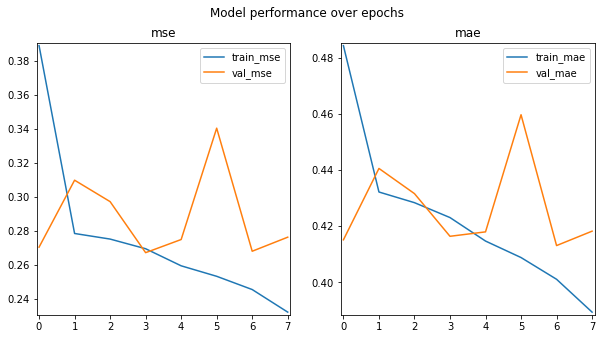

In [72]:
visualize_perf(word_history)

In [73]:
test_desc_padded = tokenize_words(test_df['product_description'])
test_st_padded = tokenize_words(test_df['search_term'])

In [74]:
test_st_padded.shape, test_desc_padded.shape

((112067, 17), (112067, 1051))

In [75]:
train_y_pred = word_model.predict([train_st_padded, train_desc_padded])
train_y = train_df['relevance'].values

In [76]:
train_mse = mean_squared_error(train_y, train_y_pred)
train_mae = mean_absolute_error(train_y, train_y_pred)
train_rmse = mean_squared_error(train_y, train_y_pred, squared=False)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.2605 on the train
Got MAE of 0.4216 on the train
Got RMSE of 0.5103 on the train


### turn below 2 cells to code from raw after having val set

In [77]:
test_y_pred = word_model.predict([test_st_padded, test_desc_padded])
test_y = test_df['relevance'].values

In [78]:
test_mse = mean_squared_error(test_y, test_y_pred)
test_mae = mean_absolute_error(test_y, test_y_pred)
test_rmse = mean_squared_error(test_y, test_y_pred, squared=False)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.2816 on the test
Got MAE of 0.4382 on the test
Got RMSE of 0.5306 on the test


In [79]:
runtime = end - start
val_rmse, val_mae = 0, 0 # Remove this line after having a val set
results.add_row(['LSTM (word level)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### d. Using our model as a feature extractor

In [80]:
fe_word_model = Model(word_model.input, word_model.layers[-3].output)

In [81]:
train_x, _ = train_data

In [82]:
train_preds_feword = fe_word_model.predict(train_x)

In [83]:
train_preds_feword.shape

(74067, 100)

In [84]:
%%time
use_saved = False

fe_rfr_path = 'models/fe_word_rfr.sav'
fe_xgb_path = 'models/fe_word_xgb.sav'

if use_saved:
    rfr_model = joblib.load(fe_rfr_path)
    xgb_model = joblib.load(fe_xgb_path)
else:
    xgb_model = XGBRegressor(use_label_encoder=False, n_jobs=-1)
    rfr_model = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)

    print('training xgb')
    start_xgb = time.time()
    xgb_model.fit(train_preds_feword, train_y)
    end_xgb = time.time()
    print('training rfr')
    start_rfr = time.time()
    rfr_model.fit(train_preds_feword, train_y)
    end_rfr = time.time()

    joblib.dump(rfr_model, fe_rfr_path)
    joblib.dump(xgb_model, fe_xgb_path)

training xgb
training rfr
CPU times: user 10min 40s, sys: 2.02 s, total: 10min 42s
Wall time: 1min 50s


#### Evaluating RandomForest

In [85]:
train_features = fe_word_model.predict([train_desc_padded, train_st_padded])
train_y_pred = rfr_model.predict(train_features)

In [86]:
train_mse = mean_squared_error(train_y_char, train_y_pred)
train_mae = mean_absolute_error(train_y_char, train_y_pred)
train_rmse = mean_squared_error(train_y_char, train_y_pred, squared=False)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.3639 on the train
Got MAE of 0.5164 on the train
Got RMSE of 0.6032 on the train


### TODO: turn below 2 cells to code from raw after having val set

In [88]:
test_features = fe_word_model.predict([test_desc_padded, test_st_padded])
test_y_pred = rfr_model.predict(test_features)

In [89]:
test_mse = mean_squared_error(test_y_char, test_y_pred)
test_mae = mean_absolute_error(test_y_char, test_y_pred)
test_rmse = mean_absolute_error(test_y_char, test_y_pred)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.3654 on the test
Got MAE of 0.5182 on the test
Got RMSE of 0.5182 on the test


In [90]:
runtime = end_rfr - start_rfr
val_rmse, val_mae = 0, 0 # Remove this line after having a val set
results.add_row(['Random Forest (word LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

#### Evaluating XGBoost

In [91]:
train_features = fe_word_model.predict([train_desc_padded, train_st_padded])
train_y_pred = xgb_model.predict(train_features)

In [92]:
train_mse = mean_squared_error(train_y_char, train_y_pred)
train_mae = mean_absolute_error(train_y_char, train_y_pred)
train_rmse = mean_squared_error(train_y_char, train_y_pred, squared=False)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 1.0763 on the train
Got MAE of 0.9198 on the train
Got RMSE of 1.0375 on the train


### TODO: turn below 2 cells to code from raw after having val set

In [93]:
test_features = fe_word_model.predict([test_desc_padded, test_st_padded])
test_y_pred = xgb_model.predict(test_features)

In [94]:
test_mse = mean_squared_error(test_y_char, test_y_pred)
test_mae = mean_absolute_error(test_y_char, test_y_pred)
test_rmse = mean_absolute_error(test_y_char, test_y_pred)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 1.0913 on the test
Got MAE of 0.9280 on the test
Got RMSE of 0.9280 on the test


In [95]:
runtime = end_xgb - start_xgb
val_rmse, val_mae = 0, 0 # Remove this line after having a val set
results.add_row(['XGBoost (word LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

# 3. Comparison of Results

Let's now review the results we've collected thorughout this assignment and discuss them.

In [96]:
print(results)

+-------------------------------+----------+------------+----------+-----------+-----------+---------+----------+
|           Model type          | Runtime  | Train RMSE | Val-RMSE | Test-RMSE | Train MAE | Val-MAE | Test-MAE |
+-------------------------------+----------+------------+----------+-----------+-----------+---------+----------+
|     LSTM (character level)    |  0.9566  |   0.5304   |    0     |   0.5334  |   0.4398  |    0    |  0.4422  |
|  Naïve benchmark (section 1c) | 78.6571  |   0.1857   |    0     |   0.4266  |   0.1493  |    0    |  0.4266  |
| Random Forest (LSTM Features) | 136.6989 |   0.3470   |    0     |   0.4475  |   0.2651  |    0    |  0.4475  |
|    XGBoost (LSTM Features)    | 24.7673  |   0.4705   |    0     |   0.4362  |   0.3838  |    0    |  0.4362  |
|       LSTM (word level)       |  2.8445  |   0.5103   |    0     |   0.5306  |   0.4216  |    0    |  0.4382  |
| Random Forest (LSTM Features) | 86.7525  |   0.6032   |    0     |   0.5182  |   0.516

# 4. Final Report